In [1]:
import numpy as np
from numpy import exp, pi, cos, sqrt, arcsin
import matplotlib.pyplot as plt
from control import tf
# from matplotlib.widgets import Slider, Button, RadioButtons

In [208]:
np.identity(2)*1.2**np.arange(1,6)[:, None, None]

array([[[1.2    , 0.     ],
        [0.     , 1.2    ]],

       [[1.44   , 0.     ],
        [0.     , 1.44   ]],

       [[1.728  , 0.     ],
        [0.     , 1.728  ]],

       [[2.0736 , 0.     ],
        [0.     , 2.0736 ]],

       [[2.48832, 0.     ],
        [0.     , 2.48832]]])

In [212]:
c = 3e8

class Fabry:
    class Mirror:
        def __init__(self, r, t):
            self.r = r
            self.t = t

        
        def coup_matrix(self, phi, k):
            '''
            phi: float
                parameter of mirror displacement from target_length
            '''
            self.coup_matrix = (np.ones((len(k),1,1))*1j/self.t
                                *np.array([[-1, self.r*exp(-2j*phi)],
                                           [-self.r*exp(-2j*phi), self.r**2 + self.t**2]]))
    
    class Space:
        def __init__(self, L, n):
            self.length = L
            self.refrac_index = n
            self.optical_dist = L*n
        
        def update(self, k):
            self.coup_matrix = exp(np.array([[1j*self.optical_dist, 0],
                                             [0, -1j*self.optical_dist]])*k[:, None, None])
            self.coup_matrix[:,0,1] = self.coup_matrix[:,1,0] = 0
            
        
    def __init__(self, L0, radius, lamda=1064, r=(0.8, 1), t=(0.2, 0), m=0.1, refrac_index=1):
        '''
        L0: float
            desired length of the Fabry-Perot Cavity
        radius: array_like
            radius of curvature of the input mirror and output mirror respectively.
        lamda: float
            carrier wavelength of the laser, in nm.
        r: array_like
            reflection coefficient of the input mirror and output mirror respectively, range:0 to 1.
        t: array_like
            transmission coefficient of the input mirror and output mirror respectively, range:0 to 1.
        m: float
            phase modulation index of the laser.
        refrac_index: float
            refractive index of the space within the cavity between two mirrors, >= 1.
        '''
        r = np.array(r)
        t = np.array(t)
        radius = np.array(radius)
        if np.any(r**2 + t**2 > 1.) :
            raise ValueError("The square sum of relection coef"
                             "and transmission coef should not greater than 1.")
        self.mirror_loss = 1 - r**2 + t**2
        self.target_length = self.cavity_length = L0
        self.reflection_coef = r
        self.transmission_coef = t
        self.input_wavelength = lamda*1e-9 # nm
        self.modulation_index = m
        self.mirror1 = self.Mirror(self.reflection_coef[0], self.transmission_coef[0])
        self.mirror2 = self.Mirror(self.reflection_coef[1], self.transmission_coef[1])
        self.space = self.Space(L0, refrac_index)

    
    
    
    def cal(self, freq_offset, E_in, tuning=True, modulation=True):
        r1, r2 = self.reflection_coef
        t1, t2 = self.transmission_coef
        L = self.cavity_length 
        
        a0 = E_in
        k = 2*pi*freq_offset/c
#         a2 =  -t1*t2*exp(-1j*k*L)/(1 - r1*r2*exp(-2j*k*L))
#         a4 = (r1 -r2*(r1**2 + t1**2)*exp(-2j*k*L))/(1 - r1*r2*exp(-2j*k*L))
        
        self.wave_num = k
        self.mirror1.coup_matrix(0, k)
        self.mirror2.coup_matrix(0, k)
        self.space.update(k)
        self.coup_matrix = (self.mirror1.coup_matrix @ self.space.coup_matrix @ self.mirror2.coup_matrix)
                            
        a2 = a0/self.coup_matrix[:,0,0]
        a4 = a0*self.coup_matrix[:,1,0]/self.coup_matrix[:,0,0]
        print(self.coup_matrix[:,0,0].shape)
        self.trans_power = np.abs(a2)**2
        self.reflect_power = np.abs(a4)**2
        self.circ_power = (np.abs(a0)**2 \
                           * t1**2 \
                           /(1 + r1**2*r2**2 - 2*r1*r2*cos(2*k*L)))
    
#     def update(new_L):
#         self.cavity_length = new_L
        
#         mirror1.update()
#         mirror2.update()
#         space.update()

(20000,)


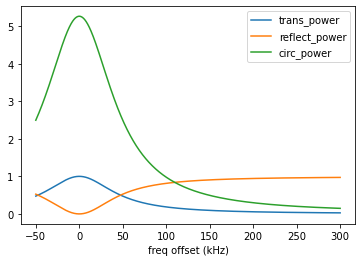

In [220]:
if __name__ == '__main__':
    r = np.array([0.9, 0.9])
    t = sqrt(1 - r**2)
    f = np.linspace(-50, 300, 20000) * 1e3
    fabry = Fabry(106.4, 0, r=r, t=t)
    fabry.cal(f, 1)
    names = ["trans_power", "reflect_power", "circ_power"]
    for i, name in zip([fabry.trans_power, fabry.reflect_power, fabry.circ_power],
                    names):
        plt.plot(f/1e3, i, label = name)
        plt.xlabel("freq offset (kHz)")
        plt.legend()

In [112]:
a = np.arange(1,7)
b = np.arange(1,10).reshape((3,3))
a[:,None,None]*b

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[ 2,  4,  6],
        [ 8, 10, 12],
        [14, 16, 18]],

       [[ 3,  6,  9],
        [12, 15, 18],
        [21, 24, 27]],

       [[ 4,  8, 12],
        [16, 20, 24],
        [28, 32, 36]],

       [[ 5, 10, 15],
        [20, 25, 30],
        [35, 40, 45]],

       [[ 6, 12, 18],
        [24, 30, 36],
        [42, 48, 54]]])